### Reading the corpus data

In [1]:
# Download or load data
from sklearn.datasets import fetch_20newsgroups
# corpus_news = fetch_20newsgroups(subset='all', data_home='/Data', remove=('headers', 'footers', 'quotes'))
# corpus_train = fetch_20newsgroups(subset='train', data_home='/Data' , remove=('headers', 'footers', 'quotes'))
# corpus_test = fetch_20newsgroups(subset='test', data_home='/Data', remove=('headers', 'footers', 'quotes'))

# corpus_train = fetch_20newsgroups(subset='all', data_home='scripts/dit247-nlp/a2', remove=('headers', 'footers', 'quotes'))
corpus_train = fetch_20newsgroups(subset='train', data_home='scripts/dit247-nlp/a2' , remove=('headers', 'footers', 'quotes'))
# corpus_train = fetch_20newsgroups(subset='test', data_home='scripts/dit247-nlp/a2', remove=('headers', 'footers', 'quotes'))

In [2]:
print(corpus_train.data[3])
print(corpus_train.target_names[corpus_train.target[3]])


Do you have Weitek's address/phone number?  I'd like to get some information
about this chip.

comp.graphics


### Tokenization

In [3]:
# Get spacy tokenizer
import spacy
spacy_tokenizer = spacy.load("en_core_web_sm")

In [4]:
def is_number(s):
    """
    Helper function to check if string can be coerced to number.
    """
    try:
        float(s)
        return True
    except ValueError:
        return False

# Define tokenize function
def tokenize(text, tokenizer=spacy_tokenizer.tokenizer, lowercase=True, remove_stopwords=True, remove_punctuation=True):
    """
    Returns a list of tokens. Removes spacy defined stop words and punctuation marks.
    """
    # tokens = [t.text for t in tokenizer(text) if not t.is_stop and not t.is_punct]
    tokens = []
    for t in tokenizer(text):
        # Skip if stopword
        if remove_stopwords and t.is_stop:
            continue
        # Skip if punctuation
        if remove_punctuation and t.is_punct:
            continue
        # Skip other irrelevant tokens
        irrel_tokens = ["\\", "\n", "\t", "=", ">", "<", "$", "x", "|", "/", "@", "_"]
        if any(it in t.text for it in irrel_tokens):
            continue
        if t.text.isspace() or is_number(t.text):
            continue
        tokens.append(t.text)
    if lowercase:
        tokens = [t.lower() for t in tokens] 
    return tokens

In [5]:
tokenize(corpus_train.data[3])

['weitek', 'address', 'phone', 'number', 'like', 'information', 'chip']

### Make a vocabulary of relevant tokens

In [6]:
from collections import Counter

freqs = Counter()
for x in corpus_train.data:
    for t in tokenize(x):
        freqs[t] += 1


In [7]:
# Remove tokens with less than 10 occurences
freqs = Counter({token: count for token, count in freqs.items() if count >= 25})

In [8]:
freqs.most_common(10)

[('x', 5160),
 ('people', 4101),
 ('like', 3961),
 ('know', 3487),
 ('use', 3179),
 ('think', 3007),
 ('time', 2956),
 ('new', 2591),
 ('good', 2504),
 ('way', 2034)]

In [9]:
# Least common
freqs.most_common()[:-11:-1]

[('ordnance', 25),
 ('anania', 25),
 ('cdi', 25),
 ('bayonet', 25),
 ('surfaces', 25),
 ('dominant', 25),
 ('sheath', 25),
 ('simtel20', 25),
 ('portland', 25),
 ('sci.astro', 25)]

In [10]:
# Number of unique tokens
len(freqs)

5938

In [11]:
# Sum of token occurences in training documents
ssum = 0
for (_, s) in freqs.items():
    ssum += s
print(f"total tokens = {ssum}")

total tokens = 750267


In [12]:
# Make a vocabulary of only the relevant tokens
# (we discard the frequencies)
vocabulary = list(freqs.keys())
len(vocabulary)

5938

In [13]:
# Make a vocabulary with mappings
vocabulary_mappings = {}
for word in freqs.keys():
    vocabulary_mappings[word] = len(vocabulary_mappings)


### Preprocess text data

In [14]:
def process_text(text, vocabulary):
    # Tokenize text
    text_tokens = tokenize(text)
    
    # Keep only relevant tokens based on vocabulary
    processed_text_tokens = [t for t in text_tokens if t in vocabulary]
    
    return processed_text_tokens

In [15]:
# Preprocess all texts in training data
X_train = [process_text(text, vocabulary) for text in corpus_train.data]
len(X_train)


11314

In [16]:
# Get topic labels from training data
Y_train = corpus_train.target
Y_train_label = [corpus_train.target_names[index] for index in Y_train]

### LDA

Create a sparse document-term matrix

In [17]:
# Create Document-Term matrix
# where each row corresponds to a document
# and each column corresponds to a token
# the values are frequencies of token in document
# note: this will be a very large and sparse matrix
import numpy as np
from scipy.sparse import lil_matrix

# Initialize a sparse matrix with dimensions given by len(X_train) and len(vocabulary)
doc_term_matrix = lil_matrix((len(X_train), len(vocabulary)), dtype=np.int16)

# Iterate through X_train
for i, doc in enumerate(X_train):
    # Iterate through the tokens in the document
    for token in doc:
        # If the token is in your vocabulary
        if token in vocabulary_mappings:
            # Increment the matrix at the current document index and the token's index
            doc_term_matrix[i, vocabulary_mappings[token]] += 1


In [18]:
# 11,314 - number of documents
# 11,303 - number of tokens in vocabulary
print(doc_term_matrix.shape)


(11314, 5938)


Initialize LDA parameters:
* Topic assignment for each word in each documnet (D x V = value is topic)
* Topic distribution over each document (D x T = value is count)
* Word distribution over each topic (T x V = value is count)
* Count of words corresponding to each topic (T = value is count)

D - number of documents  
V - number of words in vocabulary  
T - number of topics  

In [22]:
import numpy as np

# Get the number of documents in the corpus
num_docs = len(X_train)

# Get the size of the vocabulary
num_words = len(vocabulary)

# Define the number of topics for the LDA model
num_topics = 10

# Initialize LDA parameters
# Topic assignments for each word in each document
topic_assignments = np.zeros((num_docs, num_words), dtype=int)
# The topic distribution per document
doc_topic_counts = np.zeros((num_docs, num_topics), dtype=int)
# The word distribution per topic
topic_word_counts = np.zeros((num_topics, num_words), dtype=int)
# Total word counts per topic
topic_counts = np.zeros(num_topics, dtype=int)

# Randomly assign a topic to each word in each document and update the count matrices
for d in range(num_docs):
    if d % 1000 == 0:
        print(f"{d}/{num_docs}")
    for w in doc_term_matrix[d].nonzero()[1]:
        # Randomly assign a topic to the current word
        t = np.random.randint(num_topics)
        topic_assignments[d, w] = t

        # Update topic distribution per document
        doc_topic_counts[d, t] += 1

        # Update word distribution per topic
        topic_word_counts[t, w] += 1

        # Update the total count of words assigned to the current topic
        topic_counts[t] += 1


0/11314
1000/11314
2000/11314
3000/11314
4000/11314
5000/11314
6000/11314
7000/11314
8000/11314
9000/11314
10000/11314
11000/11314


### Collapsed Gibbs sampling

In [23]:
def collapsed_gibbs_sampling(num_docs, num_words,
                             topic_assignments, doc_topic_counts,
                             topic_word_counts, topic_counts,
                             alpha=0.1, beta=0.1, num_iters=100):
    # Perform Collapsed Gibbs Sampling
    # Iterate over the number of specified iterations
    for i in range(num_iters):
        print(f"{i}/{num_iters}")
        # Iterate over each document
        for d in range(num_docs):
            # Iterate over each word in the document
            for w in doc_term_matrix[d].nonzero()[1]:
                # Get the current topic assignment for the word
                t = topic_assignments[d, w]
                
                # Decrement the counts for the current word and topic assignment
                doc_topic_counts[d, t] -= 1
                topic_word_counts[t, w] -= 1
                topic_counts[t] -= 1
                
                # Calculate the conditional probability of each topic for the current word
                # Topic distribution for this document (+ alpha)
                # times
                # Topic distribution for this word (+ beta)
                # divided by
                # Word count distribution over topics + size of vocabulary scaled by beta
                p_t = (doc_topic_counts[d] + alpha) * (topic_word_counts[:, w] + beta) / (topic_counts + beta * num_words)
                
                # Sample a new topic assignment from the conditional distribution
                t = np.random.multinomial(1, p_t / p_t.sum()).argmax()
                
                # Assign the new topic to the word
                topic_assignments[d, w] = t
                
                # Increment the counts for the new word and topic assignment
                doc_topic_counts[d, t] += 1
                topic_word_counts[t, w] += 1
                topic_counts[t] += 1
    
    # Return the updated topic assignments and count matrices
    return topic_assignments, doc_topic_counts, topic_word_counts, topic_counts


In [24]:
# gibbs_results = collapsed_gibbs_sampling(num_docs, num_words,
#                                          topic_assignments, doc_topic_counts,
#                                          topic_word_counts, topic_counts)
# final_topic_assignments, final_doc_topic_counts, final_topic_word_counts, final_topic_counts = gibbs_results



gibbs_results = collapsed_gibbs_sampling(num_docs, num_words,
                                         topic_assignments, doc_topic_counts,
                                         topic_word_counts, topic_counts, alpha=0.1, beta=0.1, num_iters=10)
final_topic_assignments, final_doc_topic_counts, final_topic_word_counts, final_topic_counts = gibbs_results


# np.save('final_topic_assignments.npy', final_topic_assignments)
# np.save('final_doc_topic_counts.npy', final_doc_topic_counts)
# np.save('final_topic_word_counts.npy', final_topic_word_counts)
# np.save('final_topic_counts.npy', final_topic_counts)

0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10


### analysis

In [25]:
# final_topic_assignments = np.load('final_topic_assignments.npy')
# final_doc_topic_counts = np.load('final_doc_topic_counts.npy')
# final_topic_word_counts = np.load('final_topic_word_counts.npy')
# final_topic_counts = np.load('final_topic_counts.npy')

In [26]:
def get_most_common(n, vocabulary, topic_word_counts, tot_word_counts=None):
    """
    get the n most common words in each topic
    """
    vocabulary = np.array(vocabulary)

    most_common_words = []
    # iterate over all topics
    for t in topic_word_counts:
        
        if tot_word_counts is not None:
            # get the relative frequencies
            relative_frequencies = t/tot_word_counts
            # sort word counts in descending, get the n most common
            top_word_indices = relative_frequencies.argsort()[::-1][:n]
        else:
            # sort word counts in descending, get the n most common
            top_word_indices = t.argsort()[::-1][:n]

        most_common_words.append(vocabulary[top_word_indices])
    
    return most_common_words


corpus_word_counts = doc_term_matrix.sum(axis=0).A1

most_common_words_raw = get_most_common(20, vocabulary, final_topic_word_counts)
most_common_words_rel_freq = get_most_common(20, vocabulary, final_topic_word_counts, tot_word_counts=corpus_word_counts)

for t_raw, t_freq in zip(most_common_words_raw, most_common_words_rel_freq):
    
    print(f'''{'-'*50}
    RAW COUNT: {t_raw}
    ---
    FREQ COUNT: {t_freq}''')


--------------------------------------------------
    RAW COUNT: ['thanks' 'use' 'know' 'like' 'help' 'program' 'problem' 'available'
 'system' 'windows' 'mail' 'file' 'files' 'work' 'hi' 'x' 'find'
 'software' 'appreciated' 'ftp']
    ---
    FREQ COUNT: ['displaying' 'copying' 'icons' 'programmers' 'workshop' 'sunos' 'dial'
 'specified' 'mailed' 'revision' 'automated' 'ascii' 'graphical' 'edit'
 'packard' 'loading' 'generic' 'sparc' 'athena' 'rep']
--------------------------------------------------
    RAW COUNT: ['people' 'think' 'way' 'know' 'right' 'god' 'believe' 'said' 'good'
 'question' 'like' 'point' 'true' 'things' 'word' 'human' 'fact' 'course'
 'come' 'mean']
    ---
    FREQ COUNT: ['hearts' 'intellectual' 'plausible' 'remind' 'reactions' 'confusion'
 'wishes' 'screws' 'instances' 'attempting' 'beings' 'praise' 'clarify'
 'falls' 'firmly' 'theological' 'apologize' 'nonsense' 'silence'
 'responding']
--------------------------------------------------
    RAW COUNT: ['gover

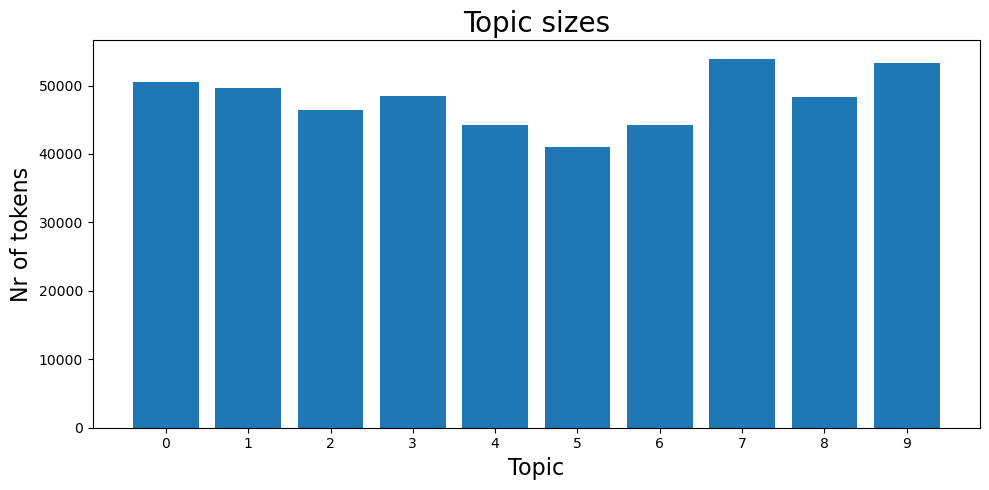

In [27]:
# barplot over nr of tokens for each topic
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
x_axis = np.arange(len(final_topic_counts))#+1

plt.bar(x_axis, final_topic_counts)
plt.title('Topic sizes', fontsize=20)
plt.xlabel('Topic', fontsize=16)
plt.xticks(x_axis)
plt.ylabel('Nr of tokens', fontsize=16)

plt.tight_layout()
plt.show()

In [28]:
# get D(v, v') - co-document frequency of word types v and v', from our D(v) - document frequencies for each word (token)
from scipy.sparse import csr_matrix, triu

# binarize doc term matrix
doc_term_matrix_binary = doc_term_matrix.copy()
doc_term_matrix_binary[doc_term_matrix_binary > 0] = 1

# sum the product of every pair of tokens frequencies, across all documents, result is a sqaure matrix
co_freq_matrix = doc_term_matrix_binary.T.dot(doc_term_matrix_binary)

# diagonal elements will be the original document frequencies, set to zero since we already have that
co_freq_matrix.setdiag(0)

# free up space
co_freq_matrix.eliminate_zeros()

# get the upper triangle since the matrix is symmetric
upper_co_freq_matrix = triu(co_freq_matrix, k=1).tocsr()

In [29]:
def umass(top_words, doc_freq, co_doc_freq, vocabulary):
    """
    Compute the umass coherence score based on the top n words from a topic.
    """

    coherence_score = 0

    M = len(top_words)

    # skip top ranked word as no other words are more probable
    for m in range(1, M):
        # get the m words vocabulary index
        word_m_index = vocabulary.index(top_words[m])
        # iterate over all words higher ranked than m
        for l in range(m):
            # get the l words vocabulary index
            word_l_index = vocabulary.index(top_words[l])

            # sum over the column for given token
            doc_freq_val = doc_freq.getcol(word_l_index).nnz
            # get co-occurence val
            co_doc_freq_val = co_doc_freq[word_m_index, word_l_index]


            coherence_score += np.log((co_doc_freq_val+1)/doc_freq_val)

    return coherence_score

# raw count
topic_coherence_scores = [umass(t, doc_term_matrix, upper_co_freq_matrix, vocabulary) for t in most_common_words_raw]

# rel.freq
# topic_coherence_scores = [umass(t, doc_term_matrix, upper_co_freq_matrix, vocabulary) for t in most_common_words_rel_freq]

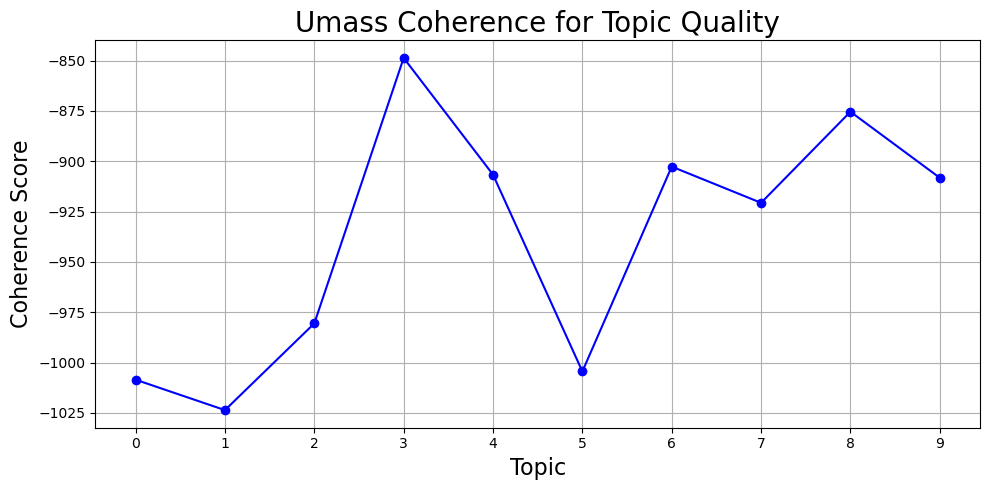

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(x_axis, topic_coherence_scores, marker='o', linestyle='-', color='b')
plt.title('Umass Coherence for Topic Quality', fontsize=20)
plt.xlabel('Topic', fontsize=16)
plt.xticks(x_axis)
plt.ylabel('Coherence Score', fontsize=16)
plt.grid(True)

plt.tight_layout()
plt.show()

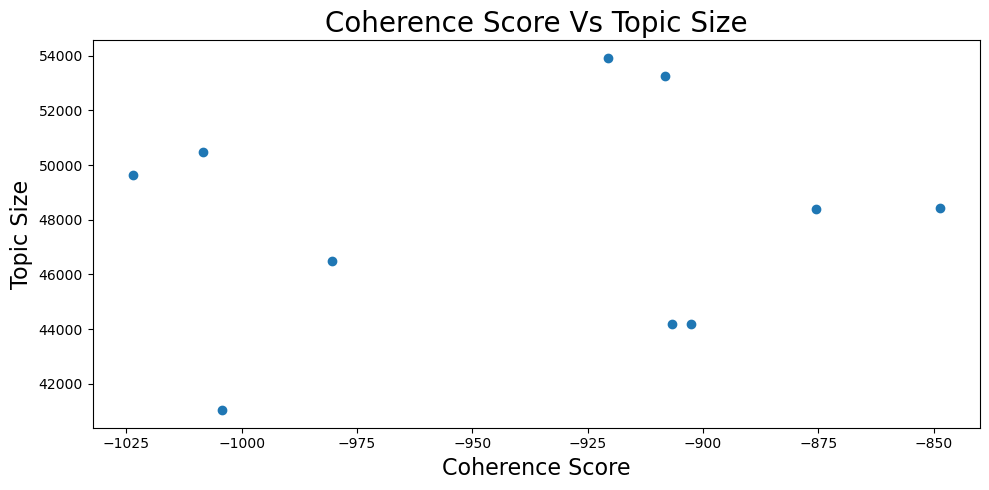

In [31]:
plt.figure(figsize=(10, 5))
plt.scatter(topic_coherence_scores, final_topic_counts)
plt.title('Coherence Score Vs Topic Size', fontsize=20)
plt.xlabel('Coherence Score', fontsize=16)
plt.ylabel('Topic Size', fontsize=16)

plt.tight_layout()
plt.show()

In [32]:
M = 5

for m in range(1, M):
    for l in range(m):
        print(m,l)

1 0
2 0
2 1
3 0
3 1
3 2
4 0
4 1
4 2
4 3
